In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import math
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['classic'])
%matplotlib inline
import cProfile as cProfile
from memory_profiler import profile
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

# Doing Image Normalization
normalize = lambda x: ((x - train_mean) / train_std).astype('float32') 
# Padding added to do random crop even at image border 
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
# Augmentation in test data is being avoided
x_test = normalize(x_test)

# Defining batch size, number of epochs and other parameters
BATCH_SIZE = 32 
MOMENTUM = 0.9 
LEARNING_RATE = 0.4 
WEIGHT_DECAY = 5e-4 
EPOCHS = 3 

# Defining data augmentation function
def data_aug(image, label):
    # Performing data augmentation 
    return image, label

# Creating train and test datasets
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len(x_train)).batch(BATCH_SIZE).prefetch(1)
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)


In [4]:
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((50000, 40, 40, 3), (50000,)), ((10000, 32, 32, 3), (10000,)))

In [5]:
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.image.random_crop(x, [32, 32, 3])), y)

In [6]:
# Using Kaiming He Initialization for kernel initialization

def init_kaiming_he(shape, dtype=tf.float32, partition_info=None):

  fan = np.prod(shape[:-1])

  bound = 1 / math.sqrt(fan)

  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [7]:
# Creating model using subclassing API 
# Same can be achieved using Functional API or Sequential API

class ConvBN(tf.keras.Model):

  def __init__(self, c_out):

    super().__init__()

    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_kaiming_he, use_bias=False)

    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)


  def call(self, inputs):

    return tf.nn.relu(self.bn(self.conv(inputs)))

In [8]:
class ResBlk(tf.keras.Model):

  def __init__(self, c_out, pool, res = False):

    super().__init__()

    self.conv_bn = ConvBN(c_out)

    self.pool = pool

    self.res = res

    if self.res:

      self.res1 = ConvBN(c_out)

      self.res2 = ConvBN(c_out)

      

  def call(self, inputs):

    h = self.pool(self.conv_bn(inputs))

    if self.res:

      h = h + self.res2(self.res1(h))

    return h 

In [9]:
class CIFAR10AutoGrad(tf.keras.Model):

  def __init__(self, c=64, weight=0.125):

    super().__init__()

    self.maxpool = tf.keras.layers.MaxPooling2D()

    self.init_conv_bn = ConvBN(c)

    self.blk1 = ResBlk(c*3, self.maxpool, res = True)

    self.blk2 = ResBlk(c*6, self.maxpool)

    self.blk3 = ResBlk(c*9, self.maxpool, res = True)

    self.pool = tf.keras.layers.GlobalMaxPool2D()

    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_kaiming_he, use_bias=False)

    self.weight = weight

# Building the model

  def call(self, x, y):

    h = self.pool(self.maxpool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x))))))

    h = self.linear(h) * self.weight

    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y) 

    loss = tf.reduce_sum(ce)

    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))

    return loss, correct

In [10]:
# Creating instance of CIFAR10AutoGrad class 
model =CIFAR10AutoGrad()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.Variable(0, name='global_step',trainable=False) #global_step is defined as the number of batches that have been seen by the graph. Each time a batch is provided, the weights are updated in such a direction that it will minimize the loss . Moreover, global_step tracks the number of batches meet so far and when it is passed to the minimize() argument list, it increases by one.
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.optimizers.SGD(lr_func, momentum=MOMENTUM, nesterov=True)# # Instantiate an optimizer.
# Add data augmentation
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.image.random_crop(x, [32, 32, 3])), y)

In [11]:
t = time.time()

@profile
def fit():

  # Creating batches for test data

  test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  #summary_writer = tf.summary.create_file_writer('./log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")))

  train_summary_writer = tf.summary.create_file_writer('./logs/train')

  test_summary_writer = tf.summary.create_file_writer('./logs/test')    


  for epoch in range(EPOCHS):

    train_loss = test_loss = train_acc = test_acc = 0.0

    with train_summary_writer.as_default():

      tf.summary.trace_on(graph=True, profiler=True) # To start capturing profiler in Tensorboard

      tf.keras.backend.set_learning_phase(1)

      for (x, y) in tqdm(train_set): # Iterating over the batches of train dataset objects .

        with tf.GradientTape() as tape:

          loss, correct = model(x, y)

          var = model.trainable_variables

          grads = tape.gradient(loss, var)

          opt.apply_gradients(zip(grads, var))

          global_step.assign_add(1)

        # Adding extra losses created during this forward pass

        train_loss += loss.numpy()

        train_acc += correct.numpy()


      tf.summary.scalar('train loss', train_loss/len_train, step=epoch)

      tf.summary.scalar('train acc', (train_acc/len_train)*100, step=epoch)

      tf.summary.trace_export(name="Train", step=epoch,profiler_outdir='./logs/train/trace') # Close Profiling when we do export

      tf.keras.backend.set_learning_phase(0)

      

    with test_summary_writer.as_default(): 

      tf.summary.trace_on(graph=True, profiler=True)

      for (x, y) in test_set:#  Iterating over the batches of train dataset objects .


        loss, correct = model(x, y)

        test_loss += loss.numpy()

        test_acc += correct.numpy()         

      tf.summary.scalar('test loss', test_loss/len_test, step=epoch)

      tf.summary.scalar('test acc', (test_acc/len_test)*100, step=epoch) 

      tf.summary.trace_export(name="Test", step=epoch,profiler_outdir='./logs/test/trace')  


      template = 'Epoch {}, lr:{:.3f},Train Loss: {:.3f},Train Accuracy: {:.3f}, Test Loss: {:.3f}, Test Accuracy: {:.3f},Time Taken: {:.2f}'

      print (template.format(epoch+1,lr_schedule(epoch+1),train_loss/len_train,(train_acc/len_train)*100,test_loss/len_test,(test_acc/len_test)*100,time.time() - t))

In [12]:
if __name__ == '__main__':
 cProfile.runctx('print (fit())', globals(),locals(),"./logs/cifar10.prof")

ERROR: Could not find file C:\Users\MANAS\AppData\Local\Temp\ipykernel_8228\1201675695.py
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
use `tf.profiler.experimental.start` instead.


  0%|          | 0/1563 [00:00<?, ?it/s]

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Epoch 1, lr:0.267,Train Loss: 1.626,Train Accuracy: 41.674, Test Loss: 1.252, Test Accuracy: 55.730,Time Taken: 2102.72


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2, lr:0.133,Train Loss: 0.975,Train Accuracy: 65.854, Test Loss: 0.843, Test Accuracy: 70.090,Time Taken: 5128.50


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3, lr:0.000,Train Loss: 0.769,Train Accuracy: 73.502, Test Loss: 0.789, Test Accuracy: 74.820,Time Taken: 7819.84
None


In [13]:
model.summary() 

Model: "cifar10_auto_grad"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv_bn (ConvBN)            multiple                  1984      
                                                                 
 res_blk (ResBlk)            multiple                  776448    
                                                                 
 res_blk_1 (ResBlk)          multiple                  665088    
                                                                 
 res_blk_2 (ResBlk)          multiple                  7969536   
                                                                 
 global_max_pooling2d (Globa  multiple                 0         
 lMaxPooling2D)                                  

In [14]:
!pip install jupyter_tensorboard
%load_ext tensorboard

In [15]:
%tensorboard --logdir logs/ --port=6066

In [16]:
from pstats import Stats
from io import StringIO

In [17]:
# Printing stats to a string
result=StringIO()
stats = Stats("./logs/cifar10.prof",stream=result)
stats.strip_dirs()
stats.sort_stats('cumulative')
stats.print_stats()

result=result.getvalue()

# Chopping the string into a csv-like buffer
result='ncalls'+result.split('ncalls')[-1]
result='\n'.join([', '.join(line.rstrip().split(None,6)) for line in result.split('\n')])
print(result)

# Saving it to the local disk
f=open('./logs/cifar10.csv','w')
f.write(result)
f.close()


ncalls, tottime, percall, cumtime, percall, filename:lineno(function)
4/1, 0.000, 0.000, 7819.840, 7819.840, {built-in, method builtins.exec}
1, 0.000, 0.000, 7819.840, 7819.840, <string>:1(<module>)
1, 0.000, 0.000, 7819.840, 7819.840, memory_profiler.py:1140(wrapper)
1, 0.005, 0.005, 7819.840, 7819.840, memory_profiler.py:715(f)
1, 7.831, 7.831, 7819.833, 7819.833, 1201675695.py:3(fit)
2220178, 6829.180, 0.003, 6829.432, 0.003, {built-in, method tensorflow.python._pywrap_tfe.TFE_Py_FastPathExecute}
4689, 1.344, 0.000, 5043.665, 1.076, backprop.py:1007(gradient)
4689, 0.093, 0.000, 5027.877, 1.072, imperative_grad.py:29(imperative_grad)
4689, 102.390, 0.022, 5027.669, 1.072, {built-in, method tensorflow.python._pywrap_tfe.TFE_Py_TapeGradient}
281340, 7.376, 0.000, 4898.969, 0.017, backprop.py:127(_gradient_function)
37512, 2.383, 0.000, 4276.038, 0.114, nn_grad.py:563(_Conv2DGrad)
37512, 1.919, 0.000, 2277.090, 0.061, gen_nn_ops.py:1483(conv2d_backprop_input)
2586979/1826140, 21.868, 

In [18]:
# Using 3 decimal places in output display
pd.set_option("display.precision", 4)

# Preventing wrapping repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

# Setting max rows displayed in output to 25
pd.set_option("display.max_rows", 100)

In [19]:
df = pd.read_csv('./logs/cifar10.csv',skipinitialspace=True)
# Displaying Column names
df.columns
# Renaming pandas col
df.rename(columns={'percall.1':'module_name'},inplace=True)
df = df.drop(['filename:lineno(function)'],axis=1)
df=df[:-1] # Deleting last row as part of data cleaning
df['total_num_calls']=""
df['total_num_calls']=df.index # Resetting index
df[['total_num_calls', 'num_recursion']] = df['total_num_calls'].str.split("/", n=1, expand=True)
# Changing the data type
convert_dict = {'module_name': str, 
                'total_num_calls': int,
                'tottime':float   ,
                'cumtime':float,
                'ncalls' :float,
                'percall':float                
                               } 
df = df.astype(convert_dict)

In [20]:
# Deriving column total time = Time taken per call * Total num of calls
df['total_time']=df['percall'] * df['total_num_calls']
df['total_time']=df['total_time'].apply(np.ceil)
# Converting to seconds
df['total_time'] = df['total_time'] / 1000.0 

In [21]:
# Create extra copy for safety 
df1=df
# Extracting only module name
df1['module_name']= df['module_name'].str.extract('(\\w+.py)')
# Dropping if any NaN exist
df1=df1.dropna(subset=['module_name'])
# Removing extra White Space
df1['module_name']=df1['module_name'].str.strip()
df2=df1
# Adding same modules' total time
df2 = df1.groupby(["module_name"])["total_time"].sum()

In [22]:
df2.head()

module_name
1201675695.py        7.820
1206929776.py    76524.052
1795491062.py        0.001
3051841859.py    10265.720
414650165.py         0.000
Name: total_time, dtype: float64

In [23]:
df2 = pd.DataFrame(df2)
df2=df2.reset_index()
df2 = df2[df2['total_time']>1]
df2 = df2.sort_values(by='total_time',ascending=False)
df2

,module_name,total_time
232,traceback_utils.py,5.9633e+06
87,dispatch.py,2.8818e+06
30,backprop.py,1.4430e+06
154,math_ops.py,4.9580e+05
35,base_layer.py,3.9217e+05
90,distribute_lib.py,2.6739e+05
120,gen_nn_ops.py,2.4683e+05
59,context.py,1.9451e+05
162,nn_grad.py,1.9438e+05
174,optimizer.py,1.8802e+05


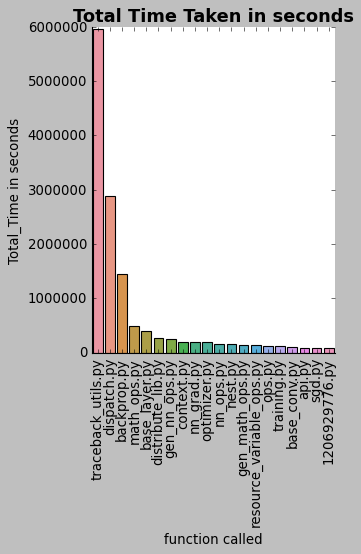

In [24]:
%matplotlib inline
# Plotting Graphs
top20 = df2.head(20)
g=sns.catplot(x='module_name', y='total_time', data=top20, kind='bar')
g.set_xticklabels(rotation=90)
g.set_xlabels("function called")
g.set_ylabels("Total_Time in seconds")
plt.title('Total Time Taken in seconds', weight='bold', fontsize=16)
plt.show()

In [25]:
# Selecting specific modules used in model building

df3 =df2[df2['module_name'].str.contains("grad") | 
        df2['module_name'].str.contains('conv')|
        df2['module_name'].str.contains('backprop')|
        df2['module_name'].str.contains('normal') |
        df2['module_name'].str.contains('tape') |
        df2['module_name'].str.contains('array') |
        df2['module_name'].str.contains('tensor') |
        df2['module_name'].str.contains('deprecat') |
        df2['module_name'].str.contains('iter') |
        df2['module_name'].str.contains('pool') |
        df2['module_name'].str.contains('layer') |
        df2['module_name'].str.contains('ops') |
        df2['module_name'].str.contains('custom') ]     

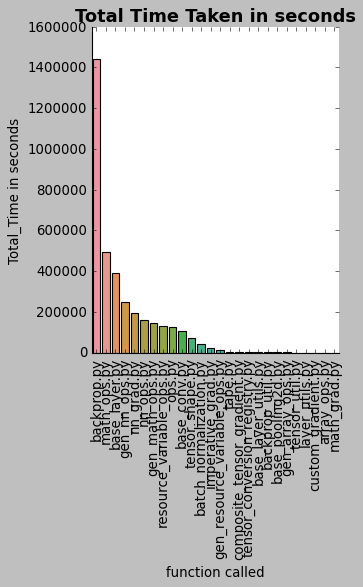

In [26]:
%matplotlib inline
# Plotting
top25_custom= df3[:26]
g=sns.catplot(x='module_name', y='total_time', data=top25_custom, kind='bar')
g.set_xticklabels(rotation=90)
g.set_xlabels("function called")
g.set_ylabels("Total_Time in seconds")
plt.title('Total Time Taken in seconds', weight='bold', fontsize=16)
plt.show()

In [27]:
!pip install snakeviz

In [28]:
# Visualising using SnakeViz
%load_ext snakeviz
%snakeviz fit()

ERROR: Could not find file C:\Users\MANAS\AppData\Local\Temp\ipykernel_8228\1201675695.py


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1, lr:0.267,Train Loss: 0.677,Train Accuracy: 76.910, Test Loss: 0.837, Test Accuracy: 73.060,Time Taken: 10191.76


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2, lr:0.133,Train Loss: 0.606,Train Accuracy: 79.260, Test Loss: 0.537, Test Accuracy: 81.410,Time Taken: 12751.49


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3, lr:0.000,Train Loss: 0.555,Train Accuracy: 81.082, Test Loss: 0.580, Test Accuracy: 80.900,Time Taken: 15340.80
 
*** Profile stats marshalled to file 'C:\\Users\\MANAS\\AppData\\Local\\Temp\\tmp7a1pwbx9'.
Embedding SnakeViz in this document...


In [29]:
!pip install memory_profiler
%load_ext memory_profiler

In [30]:
%mprun -T mem_results.txt -f fit fit()

ERROR: Could not find file C:\Users\MANAS\AppData\Local\Temp\ipykernel_8228\1201675695.py


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1, lr:0.267,Train Loss: 0.515,Train Accuracy: 82.446, Test Loss: 0.612, Test Accuracy: 80.640,Time Taken: 17932.74


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2, lr:0.133,Train Loss: 0.486,Train Accuracy: 83.574, Test Loss: 0.552, Test Accuracy: 81.860,Time Taken: 20737.16


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3, lr:0.000,Train Loss: 0.446,Train Accuracy: 84.832, Test Loss: 0.481, Test Accuracy: 84.280,Time Taken: 23715.55


*** Profile printout saved to text file mem_results.txt. 


In [31]:
with open('mem_results.txt', 'r') as f:
    print(f.read())

Filename: C:\Users\MANAS\anaconda3\lib\site-packages\memory_profiler.py

Line #    Mem usage    Increment  Occurences   Line Contents
  1140   1694.9 MiB   1694.9 MiB           1               def wrapper(*args, **kwargs):
  1141   1694.9 MiB      0.0 MiB           1                   prof = get_prof()
  1142   1706.7 MiB     11.8 MiB           1                   val = prof(func)(*args, **kwargs)
  1143   1706.7 MiB      0.0 MiB           1                   show_results_bound(prof)
  1144   1706.7 MiB      0.0 MiB           1                   return val
